In [1]:
# Copyright (c) 2017 Ben Poole & Friedemann Zenke
# MIT License -- see LICENSE for details
# 
# This file is part of the code to reproduce the core results of:
# Zenke, F., Poole, B., and Ganguli, S. (2017). Continual Learning Through
# Synaptic Intelligence. In Proceedings of the 34th International Conference on
# Machine Learning, D. Precup, and Y.W. Teh, eds. (International Convention
# Centre, Sydney, Australia: PMLR), pp. 3987–3995.
# http://proceedings.mlr.press/v70/zenke17a.html

In [10]:
%load_ext autoreload
%autoreload 2
%pylab inline

import tensorflow as tf
slim = tf.contrib.slim
graph_replace = tf.contrib.graph_editor.graph_replace

import sys, os
sys.path.extend([os.path.expanduser('..')])
from pathint import utils
import seaborn as sns
sns.set_style("ticks")

from tqdm import trange, tqdm

# import operator
import matplotlib.colors as colors
import matplotlib.cm as cmx

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Parameters

In [11]:
select = tf.select if hasattr(tf, 'select') else tf.where

In [12]:
# Data params
input_dim = 784
output_dim = 10

# Network params
n_hidden_units = 256
activation_fn = tf.nn.relu

# Optimization params
batch_size = 64
epochs_per_task = 10

n_stats = 10

# Reset optimizer after each age
reset_optimizer = True

## Construct datasets

In [13]:
task_labels = [[0,1], [2,3]]#, [4,5], [6,7], [8,9]]
task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
# task_labels = [[0,1,2,3,4], [5,6,7,8,9]]
n_tasks = len(task_labels)
training_datasets = utils.construct_split_mnist(task_labels, split='train')
validation_datasets = utils.construct_split_mnist(task_labels, split='test')
# training_datasets = utils.mk_training_validation_splits(full_datasets, split_fractions=(0.9, 0.1))

## Construct network, loss, and updates

In [14]:
tf.reset_default_graph()

In [15]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

In [9]:
# tf.equal(output_mask[None, :], 1.0)

In [16]:
import keras.backend as K
import keras.activations as activations

output_mask = tf.Variable(tf.zeros(output_dim), name="mask", trainable=False)

def masked_softmax(logits):
    # logits are [batch_size, output_dim]
    x = select(tf.tile(tf.equal(output_mask[None, :], 1.0), [tf.shape(logits)[0], 1]), logits, -1e32 * tf.ones_like(logits))
    return activations.softmax(x)

def set_active_outputs(labels):
    new_mask = np.zeros(output_dim)
    for l in labels:
        new_mask[l] = 1.0
    sess.run(output_mask.assign(new_mask))
    print(sess.run(output_mask))
    
def masked_predict(model, data, targets):
    pred = model.predict(data)
    print(pred)
    acc = np.argmax(pred,1)==np.argmax(targets,1)
    return acc.mean()

In [17]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(n_hidden_units, activation=activation_fn, input_shape=(input_dim,)))
model.add(Dense(n_hidden_units, activation=activation_fn))
model.add(Dense(output_dim, kernel_initializer='zero', activation=masked_softmax))

In [9]:
from pathint import protocols
from pathint.optimizers import KOOptimizer
from keras.optimizers import Adam, RMSprop,SGD
from keras.callbacks import Callback
from pathint.keras_utils import LossHistory

#protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
# protocol_name, protocol = protocols.SUM_FISHER_PROTOCOL('sum')
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
# opt = SGD(1e-3)
# opt = RMSprop(lr=1e-3)
oopt = KOOptimizer(opt, model=model, **protocol)
model.compile(loss='categorical_crossentropy', optimizer=oopt, metrics=['accuracy'])
model._make_train_function()
saved_weights = model.get_weights()

history = LossHistory()
callbacks = [history]
datafile_name = "split_mnist_data_%s.pkl.gz"%protocol_name

## Train!

In [10]:
# diag_vals = dict()
# all_evals = dict()
# data = utils.load_zipped_pickle("comparison_data_%s.pkl.gz"%protocol_name)
# returns empty dict if file not found

def run_fits(cvals, training_data, valid_data, eval_on_train_set=False, nstats=1):
    acc_mean = dict()
    acc_std = dict()
    for cidx, cval_ in enumerate(tqdm(cvals)):
        runs = []
        for runid in range(nstats):
            sess.run(tf.global_variables_initializer())
            # model.set_weights(saved_weights)
            cstuffs = []
            evals = []
            print("setting cval")
            cval = cval_
            oopt.set_strength(cval)
            oopt.init_task_vars()
            print("cval is", sess.run(oopt.lam))
            for age, tidx in enumerate(range(n_tasks)):
                print("Age %i, cval is=%f"%(age,cval))
                print("settint output mask")
                set_active_outputs(task_labels[age])
                stuffs = model.fit(training_data[tidx][0], training_data[tidx][1], batch_size, epochs_per_task, callbacks=callbacks)
                oopt.update_task_metrics(training_data[tidx][0], training_data[tidx][1], batch_size)
                oopt.update_task_vars()
                ftask = []
                for j in range(n_tasks):
                    set_active_outputs(task_labels[j])
                    if eval_on_train_set:
                        f_ = masked_predict(model, training_data[j][0], training_data[j][1])
                    else:
                        f_ = masked_predict(model, valid_data[j][0], valid_data[j][1])
                    ftask.append(np.mean(f_))
                evals.append(ftask)
                cstuffs.append(stuffs)

                # Re-initialize optimizater variables
                if reset_optimizer:
                    oopt.reset_optimizer()

            evals = np.array(evals)
            runs.append(evals)
        
        runs = np.array(runs)
        acc_mean[cval_] = runs.mean(0)
        acc_std[cval_] = runs.std(0)
    return dict(mean=acc_mean, std=acc_std)


In [11]:
# cvals = np.concatenate(([0], np.logspace(-2, 2, 10)))
# cvals = np.concatenate(([0], np.logspace(-1, 2, 2)))
# cvals = np.concatenate(([0], np.logspace(-2, 0, 3)))
cvals = np.logspace(-3, 3, 7)#[0, 1.0, 2, 5, 10]
cvals = [0, 1.0]
print(cvals)


[0, 1.0]


In [12]:
%%capture

recompute_data = True

if recompute_data:
    data = run_fits(cvals, training_datasets, validation_datasets, eval_on_train_set=True, nstats=n_stats)
    utils.save_zipped_pickle(data, datafile_name)

In [13]:
data = utils.load_zipped_pickle(datafile_name)
print(cvals)

[0, 1.0]


In [14]:
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=-5, vmax=np.log(np.max(list(data['mean'].keys()))))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
print(scalarMap.get_clim())

(-5, 0.0)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


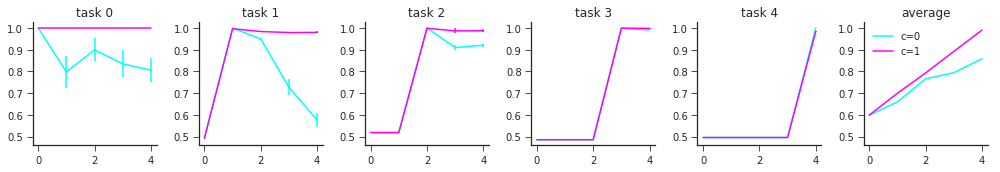

In [15]:
figure(figsize=(14, 2.5))
axs = [subplot(1,n_tasks+1,1)]#, None, None]
for i in range(1, n_tasks + 1):
    axs.append(subplot(1, n_tasks+1, i+1, sharex=axs[0], sharey=axs[0]))
    
keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        colorVal = scalarMap.to_rgba(np.log(cval))
        # axs[j].plot(evals[:, j], c=colorVal)
        axs[j].errorbar(range(n_tasks), mean_vals[:, j], yerr=std_vals[:, j]/np.sqrt(n_stats), c=colorVal)
    label = "c=%g"%cval
    average = mean_vals.mean(1)
    axs[-1].plot(average, c=colorVal, label=label)
    
for i, ax in enumerate(axs):
    ax.legend(loc='best')
    ax.set_title((['task %d'%j for j in range(n_tasks)] + ['average'])[i])
gcf().tight_layout()
sns.despine()

In [16]:
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

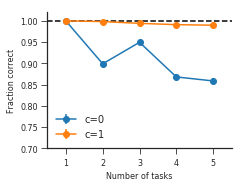

In [17]:
fig = plt.figure(figsize=(3.3,2.5))
ax = plt.subplot(111)

for cval in sorted_keys:
    mean_stuff = []
    std_stuff = []
    for i in range(len(data['mean'][cval])):
        mean_stuff.append(data['mean'][cval][i][:i+1].mean())
        std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))
    # plot(range(1,n_tasks+1), mean_stuff, 'o-', label="c=%g"%cval)
    errorbar(range(1,n_tasks+1), mean_stuff, yerr=std_stuff, fmt='o-', label="c=%g"%cval)
        
axhline(data['mean'][cval][0][0], linestyle='--', color='k')
xlabel('Number of tasks')
ylabel('Fraction correct')
legend(loc='best')
xlim(0.5, 5.5)
ylim(0.7, 1.02)
# grid('on')
# sns.despine()
simple_axis(ax)

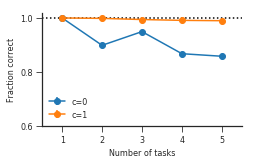

In [18]:
fig = plt.figure(figsize=(3.3,2.0))
ax = plt.subplot(111)

plot_keys =sorted(data['mean'].keys())# [0,1]

for cval in plot_keys:
    mean_stuff = []
    std_stuff = []
    for i in range(len(data['mean'][cval])):
        mean_stuff.append(data['mean'][cval][i][:i+1].mean())
        std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))
    # plot(range(1,n_tasks+1), mean_stuff, 'o-', label="c=%g"%cval)
    errorbar(range(1,n_tasks+1), mean_stuff, yerr=std_stuff, fmt='o-', label="c=%g"%cval)
        
axhline(data['mean'][cval][0][0], linestyle=':', color='k')
xlabel('Number of tasks')
ylabel('Fraction correct')
legend(loc='best', fontsize=8)
xlim(0.5, 5.5)
plt.yticks([0.6,0.8,1.0])
ylim(0.6, 1.02)
# grid('on')
# sns.despine()
simple_axis(ax)
plt.subplots_adjust(left=.15, bottom=.18, right=.99, top=.97)
plt.savefig("split_mnist_accuracy.pdf")

[0, 1.0]


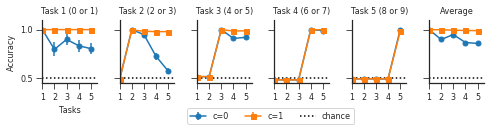

In [20]:
figure(figsize=(7, 1.8))
axs = [subplot(1,n_tasks+1,1)]
for i in range(1,n_tasks+1):
    axs.append(subplot(1, n_tasks+1, i+1, sharex=axs[0], sharey=axs[0]))
fmts = ['o', 's']

plot_keys =sorted(data['mean'].keys())
# plot_keys = [0]
print(plot_keys)

for i, cval in enumerate(plot_keys):
    label = "c=%g"%cval
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks+1):
        sca(axs[j])
        errorbar_kwargs = dict(fmt="%s-"%fmts[i], markersize=5)
        if j < n_tasks:
            # print(j,mean_vals[:, j])
            norm= np.sqrt(n_stats) # np.sqrt(n_stats) for SEM or 1 for STDEV
            axs[j].errorbar(np.arange(n_tasks)+1, mean_vals[:, j], yerr=std_vals[:, j]/norm, label=label, **errorbar_kwargs)
        else:
            mean_stuff = []
            std_stuff = []
            for i in range(len(data['mean'][cval])):
                mean_stuff.append(data['mean'][cval][i][:i+1].mean())
                #std_stuff.append(data['mean'][cval][i][:i+1].std()/np.sqrt(n_stats))
                std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))
            # plot(range(1,n_tasks+1), mean_stuff, 'o-', label="c=%g"%cval)
            errorbar(range(1,n_tasks+1), mean_stuff, yerr=std_stuff, label="c=%g"%cval, **errorbar_kwargs)
        plt.xticks(np.arange(5)+1)
        plt.xlim((1.0,5.5))
        if j == 0:
            axs[j].set_yticks([0.5,1])
        else:
            setp(axs[j].get_yticklabels(), visible=False)
        plt.ylim((0.45,1.1))

for i, ax in enumerate(axs):
    if i < n_tasks:
        ax.set_title((['Task %d (%d or %d)'%(j+1,task_labels[j][0], task_labels[j][1]) for j in range(n_tasks)] + ['average'])[i], fontsize=8)
    else:
        ax.set_title("Average", fontsize=8)
    #ax.set_title((['Task %d'%(j+1) for j in xrange(n_tasks)] + ['average'])[i], fontsize=8)
    # ax.axhline(0.5, linestyle=':', color='k')
    ax.axhline(0.5, color='k', linestyle=':', label="chance", zorder=0)
handles, labels = axs[-1].get_legend_handles_labels()
# Reorder legend so chance is last
axs[-1].legend([handles[j] for j in [1,2,0]], [labels[j] for j in [1,2,0]], loc='lower right', fontsize=8, bbox_to_anchor=(-1.3, -.7), ncol=3, frameon=True)
# axs[-1].legend(loc='lower right', fontsize=8, bbox_to_anchor=(-1.3, -.7), ncol=3, frameon=True)
    
axs[0].set_xlabel("Tasks")
axs[0].set_ylabel("Accuracy")
gcf().tight_layout()
sns.despine()
plt.savefig("split_mnist_tasks.pdf")